### Add the rectified images together and write out as a fits file

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.io import ascii, fits
from astropy.visualization import MinMaxInterval, AsinhStretch, HistEqStretch, ImageNormalize
from scipy import interpolate
from scipy.optimize import curve_fit
%matplotlib inline
#%matplotlib ipympl

In [2]:
# get a list of the rectified images
path = '../191008/'
files = glob.glob(path+'proc/'+'rectified*.fits')
filenumbers = [f.split('/')[-1].strip('rectified').strip('.fits') for f in files]

In [3]:
# get the wavecal file
calfile = 'wavecal1-28'
wc_hdu = fits.open(path+'cal/'+calfile+'.fits')
wc_hd = wc_hdu[0].header
orders = wc_hd['ORDERS'].split(',')
norders = wc_hd['NORDERS']

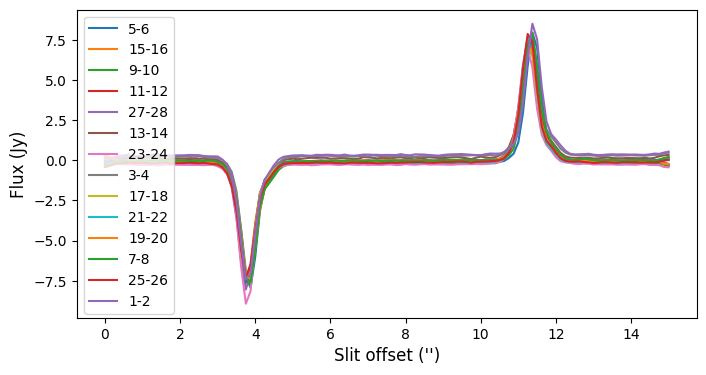

In [4]:
# check alignments
# should check by order
# generally good alignment but perhaps some should be rejected?
order = 110
j1 = 30           # starting point of first order -- figured out by hand
dj_AB = 121       # width of each order -- this should match the size of the number of rows in the order extension
dj_blank = 30     # gap between orders -- this is figured out by eye and assumed to be the same for all orders
j0 = j1 + (dj_AB + dj_blank) * (order - 99)
wavecal = wc_hdu[3+order-99].data
wl = wavecal[0, 0, 1:]
slitpos = wavecal[0, 1:, 0]

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel(r"Slit offset ('')", fontsize=12)
ax.set_ylabel(r"Flux (Jy)", fontsize=12)
for n, file in enumerate(files):
    hdu = fits.open(file)
    flux = hdu[0].data
    var = hdu[1].data
    hdu.close()

    order_flux = flux[j0:j0+dj_AB, :]
    im_median = np.median(order_flux, axis=1)
    ax.plot(slitpos, im_median, label=filenumbers[n])
ax.legend()


In [5]:
# weighted average of the images
for n, file in enumerate(files):
    hdu = fits.open(file)
    flux = hdu[0].data
    var = hdu[1].data
    hd_comb = hdu[0].header
    hdu.close()

    w = 1 / var
    if n == 0:
        flux_sum = w * flux
        weights_sum = w
    else:
        flux_sum += w * flux
        weights_sum += w

flux_comb = flux_sum / weights_sum
var_comb = 1 / weights_sum

Text(0.5, 1.0, 'Combined Variance')

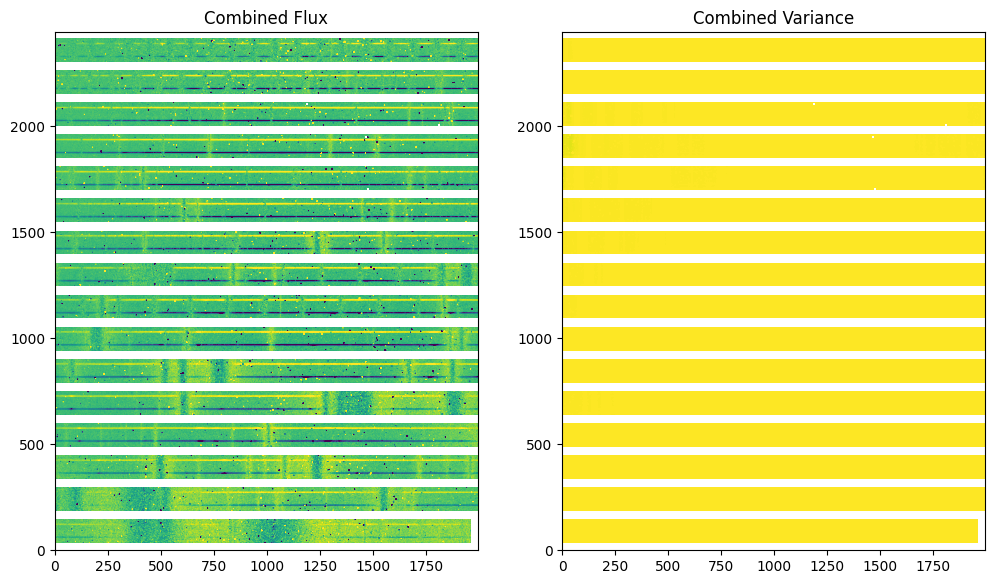

In [6]:
fig = plt.figure(figsize=(12, 7))
ax1 = plt.subplot(121)
#flux_norm = ImageNormalize(flux_comb, interval=MinMaxInterval(), stretch=HistEqStretch(flux_comb))
flux_norm = ImageNormalize(flux_comb, vmin=-5, vmax=5, stretch=AsinhStretch(0.3))
ax1.imshow(flux, origin='lower', norm=flux_norm)
ax1.set_title('Combined Flux')
ax2 = plt.subplot(122)
var_norm = ImageNormalize(var_comb, interval=MinMaxInterval(), stretch=HistEqStretch(var))
ax2.imshow(var, origin='lower', norm=var_norm)
ax2.set_title('Combined Variance')

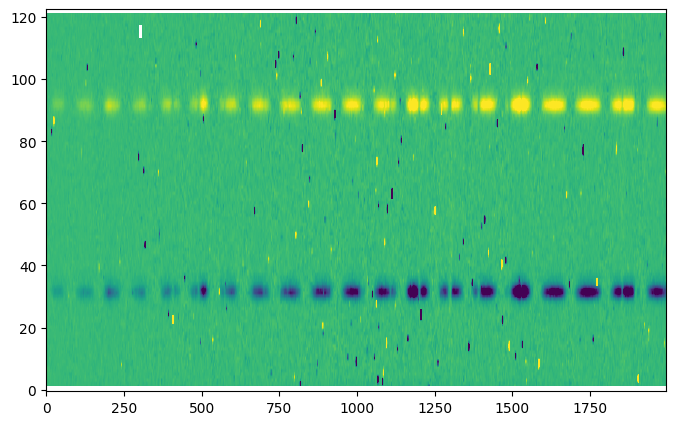

In [7]:
# plot a given order (between 99 and 114)
# this is, for now, figured out by hand and is critical that it be done right for matching to the slit offset later
# it would be good to code in some checks on image size compared to the wavelcal file order extensions
# and perhaps edge detection to do this automatically in the future
fig, ax = plt.subplots(figsize=(8, 8))
j1 = 30           # starting point of first order -- figured out by hand
dj_AB = 121       # width of each order -- this should match the size of the number of rows in the order extension
dj_blank = 30     # gap between orders -- this is figured out by eye and assumed to be the same for all orders
dj_plot = 1       # cosmetic gap to make the plot look nice

order = 114
j0 = j1 + (dj_AB + dj_blank) * (order - 99)
ax.imshow(flux_comb[j0-dj_plot:j0+dj_AB+dj_plot, :], origin='lower', norm=flux_norm, aspect=10)

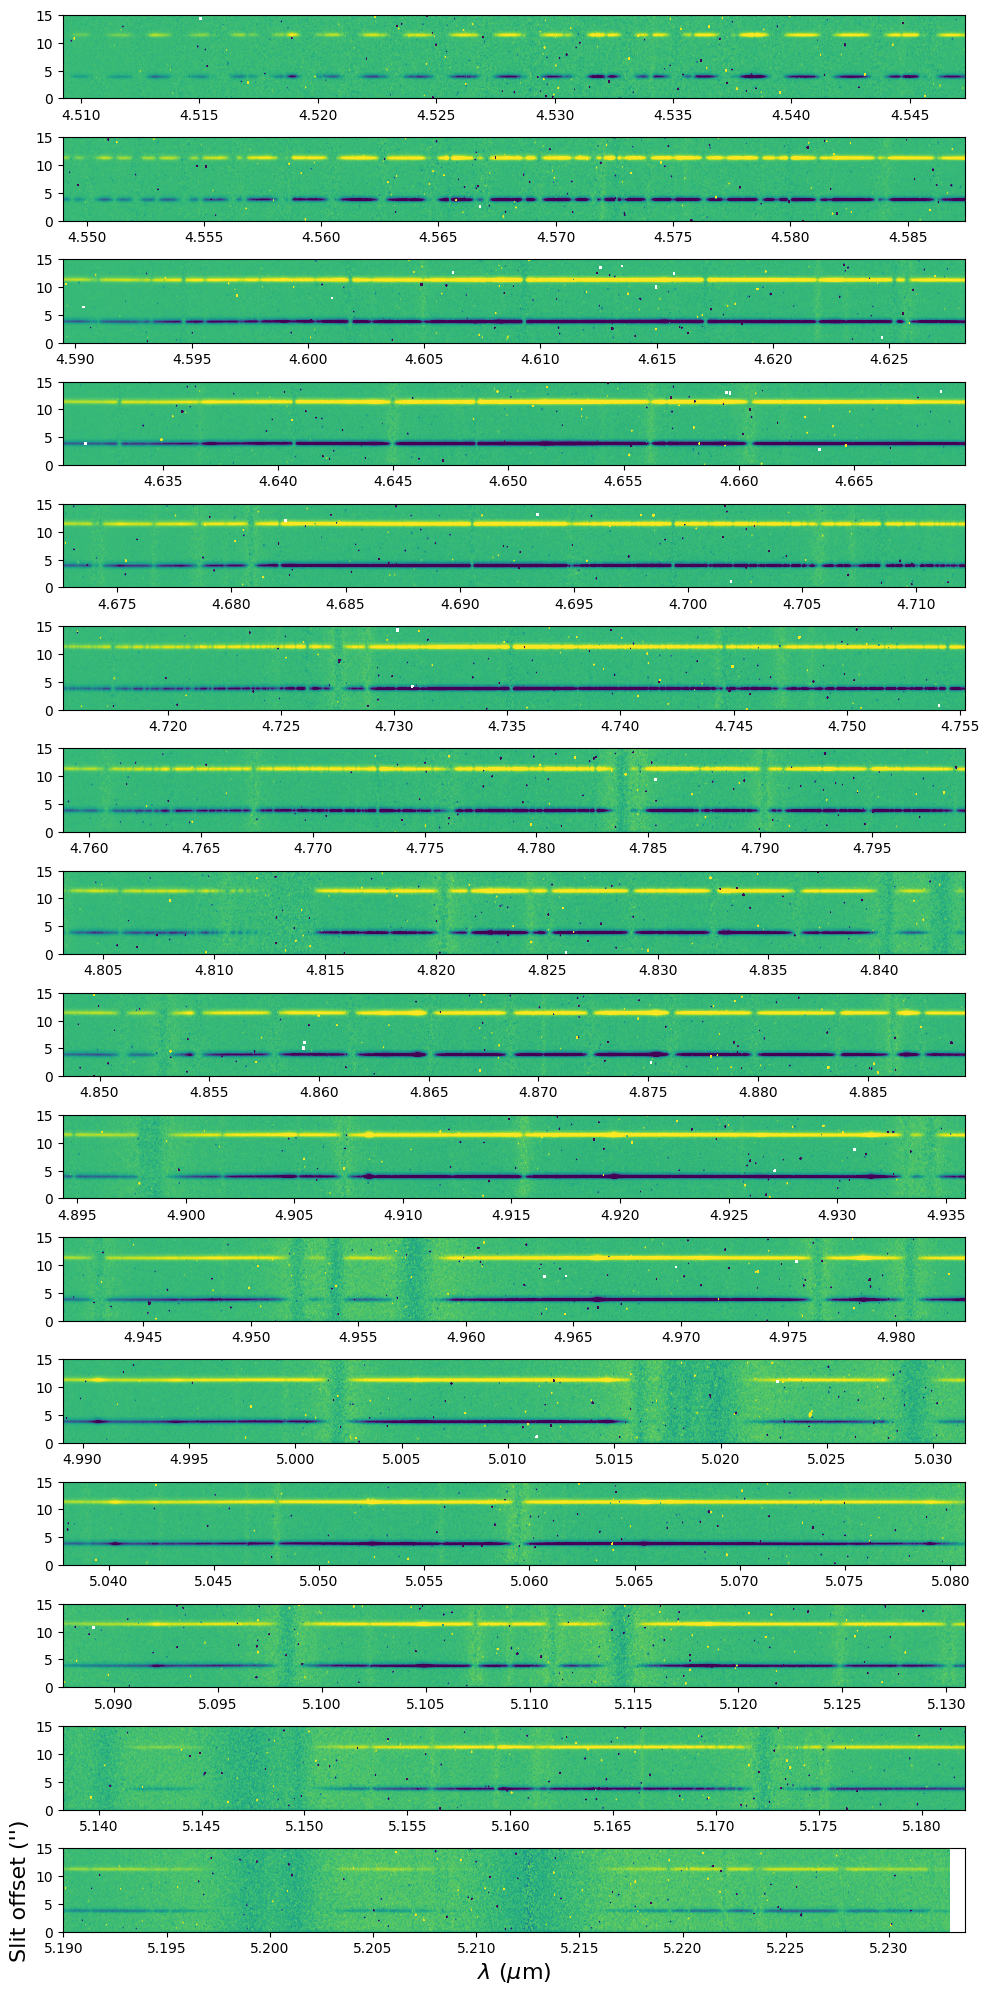

In [8]:
# plot all the orders
fig = plt.figure(figsize=(10, 20))

for n in range(norders):
    wavecal1 = wc_hdu[3+n].data
    wl = wavecal1[0, 0, 1:]
    slitpos = wavecal1[0, 1:, 0]

    extent = [wl.min(), wl.max(), slitpos.min(), slitpos.max()]
    #print(f'Order = {n:2d}, Min/Max wavelength = {wl.min()}, {wl.max()}')
    ax = fig.add_subplot(norders, 1, norders-n)
    j0 = j1 + (dj_AB + dj_blank) * n
    order1_flux = flux_comb[j0:j0+dj_AB, :]
    order1_var = var_comb[j0:j0+dj_AB, :]
    ax.imshow(order1_flux, origin='lower', norm=flux_norm, extent=extent, aspect='auto')

    if n == 0:
        ax.set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=16)
        ax.set_ylabel(r"Slit offset ('')", fontsize=16)

plt.tight_layout()
plt.savefig('rectified_orders.png')

In [9]:
# write out the combined data as a fits file
# TBD: include more metadata in the header
hdu_flux = fits.PrimaryHDU(flux_comb, header=hd_comb)
hdu_var = fits.ImageHDU(var_comb)
hdu_list = fits.HDUList([hdu_flux, hdu_var])
hdu_list.writeto(path+'proc/'+'combined.fits')